<a href="https://colab.research.google.com/github/pratik-poudel/financial_news_stock/blob/master/regression_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlxtend --upgrade

     |████████████████████████████████| 1.4MB 12.3MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional,LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.utils import to_categorical, plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score,precision_recall_fscore_support
from sklearn.utils import resample, shuffle


from mlxtend.plotting import plot_confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

# Financial Phrase Bank 

In [3]:
fin_data = pd.read_table('/content/Sentences_50Agree.txt', delimiter='\r\n')

In [4]:
values = np.array([fin_data.values[i][0].split('@') for i in range(fin_data.shape[0])])
data = pd.DataFrame({'sentence': values[:, 0], 'sentiment':values[:, 1]})

In [5]:
data.head(2)

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative


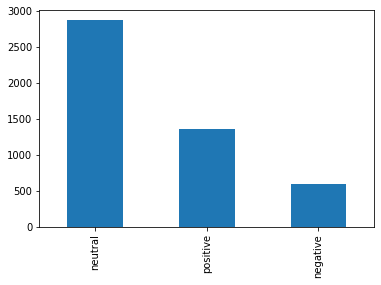

In [6]:
data['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [7]:
X= data.sentence
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=60, test_size=0.2)

In [8]:
X_train.shape, X_test.shape, X.shape

((3876,), (969,), (4845,))

In [9]:
neu_index = y_train[y_train == 'neutral'].index
pos_index = y_train[y_train == 'positive'].index
neg_index = y_train[y_train == 'negative'].index

In [10]:

# Down-sample neutral class
X_train_neu, y_train_neu = resample(X_train.loc[neu_index], y_train.loc[neu_index],
                                    n_samples=len(pos_index), replace=False,
                                    random_state=60)

# Up-sample negative class
X_train_neg, y_train_neg = resample(X_train.loc[neg_index], y_train.loc[neg_index],
                                    n_samples=len(pos_index), replace=True,
                                    random_state=60)

In [11]:
# Combine resampled classes
X_train_resample = X_train.loc[pos_index].append([X_train_neu, X_train_neg])
y_train_resample = y_train.loc[pos_index].append([y_train_neu, y_train_neg])

# Shuffle samples
X_train_resample, y_train_resample = shuffle(X_train_resample, y_train_resample, random_state=7)

# Display new class counts
print(y_train_resample.value_counts())

neutral     1090
negative    1090
positive    1090
Name: sentiment, dtype: int64


# Prepare Data for model

In [12]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resample)
X_train_seq = tokenizer.texts_to_sequences(X_train_resample)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
# Make sequences of equal length 
max_len = np.max([len(X_train_seq[i]) for i in range(len(X_train_seq))])
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

In [14]:
max_len

71

In [15]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train)
y_train_seq = to_categorical(le.transform(y_train_resample))
y_test_seq = to_categorical(le.transform(y_test))

# EMBEDDINGS

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-03-19 08:58:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-19 08:58:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-19 08:58:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [17]:
dict_w2v = {}
with open('/content/glove.6B.100d.txt', 'r') as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 100:
            dict_w2v[word] = vector
        else:
            print("There is issue with " + word)

In [18]:
print("dictionary size :" ,len(dict_w2v) )

dictionary size : 400000


In [19]:
words_found = set()
words_not_found = set()
for word in tokenizer.word_index:
    vec = dict_w2v.get(word)
    if vec is not None:
        words_found.add(word)
    else:
        words_not_found.add(word)
len(words_found), len(words_not_found), len(tokenizer.word_index)

(6187, 918, 7105)

In [20]:
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index)
embedding_matrix = np.zeros((VOCAB_SIZE +1, EMBEDDING_DIM))

In [21]:
unk_cnt = 0
unk_set = set()
for word, i in tokenizer.word_index.items():
    emb_vector = dict_w2v.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
unk_cnt

918

In [22]:
X_train_seq.shape, y_train_seq.shape

((3270, 71), (3270, 3))

Epoch 1/15
52/52 [==============================] - 21s 40ms/step - loss: 1.0666 - recall: 0.2493 - val_loss: 1.2088 - val_recall: 0.1971
Epoch 2/15
52/52 [==============================] - 1s 21ms/step - loss: 0.8699 - recall: 0.4484 - val_loss: 0.9280 - val_recall: 0.5129
Epoch 3/15
52/52 [==============================] - 1s 21ms/step - loss: 0.7277 - recall: 0.6300 - val_loss: 0.6899 - val_recall: 0.6574
Epoch 4/15
52/52 [==============================] - 1s 21ms/step - loss: 0.6253 - recall: 0.7017 - val_loss: 0.7940 - val_recall: 0.6512
Epoch 5/15
52/52 [==============================] - 1s 21ms/step - loss: 0.5161 - recall: 0.7685 - val_loss: 0.8256 - val_recall: 0.6378
Epoch 6/15
52/52 [==============================] - 1s 20ms/step - loss: 0.4816 - recall: 0.7840 - val_loss: 0.8999 - val_recall: 0.6739
Epoch 7/15
52/52 [==============================] - 1s 21ms/step - loss: 0.4501 - recall: 0.8146 - val_loss: 0.6677 - val_recall: 0.7110
Epoch 8/15
52/52 [======================

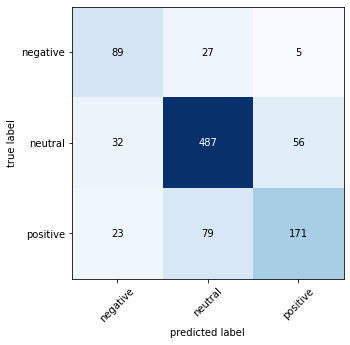

          1-Precision  2-Recall  3-F1 score  4-Support
negative        0.618     0.736       0.672        121
neutral         0.821     0.847       0.834        575
positive        0.737     0.626       0.677        273


In [23]:
np.random.seed(60)
model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len, trainable=True))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat')) #{"sum", "mul", "ave", "concat", None}
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[ 
                                                                            #  'Precision', 
                                                                             'Recall', 
                                                                            #  'accuracy'
                                                                             ])
# model.summary()

batch_size = 64
epochs = 15

model.fit(X_train_seq, y_train_seq,validation_data=(X_test_seq, y_test_seq), 
          batch_size=batch_size, verbose=1, epochs=epochs, shuffle=True)

preds = model.predict(X_test_seq, batch_size=batch_size)
true_y = np.argmax(y_test_seq, axis=1)
pred_y = np.argmax(preds, axis=1)

c_mat = confusion_matrix(true_y, pred_y)
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(true_y, pred_y, average=None)

# Print precision, recall, f1 score and support
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

# Prepare NEPSE DATA

In [204]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']
indices['date'] = pd.to_datetime(indices['date'])
indices = indices[indices['date'] < '2019-07-06']

In [205]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']
news_df.reset_index(drop=True, inplace=True)

In [206]:
news_df = news_df[news_df['date'].isin(indices['date'])].reset_index(drop=True)

In [207]:
indices = indices[indices['date'].isin(news_df['date'])].reset_index(drop=True)

In [208]:
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)
indices['target'] = np.where(indices['pct_change'] < 0 , 0, 1)

In [209]:
news_df = news_df[['date', 'content']]

In [210]:
indices

,no_name,date,index,abs_change,pct_change,target
0,1590,2014-02-02,775.92,-5.54,-0.70,0
1,1589,2014-02-03,769.51,-6.41,-0.83,0
2,1588,2014-02-04,774.91,5.40,0.70,1
3,1587,2014-02-05,781.38,6.47,0.83,1
4,1586,2014-02-06,785.78,4.40,0.56,1
...,...,...,...,...,...,...
1233,351,2019-06-24,"1,260.10",5.75,0.46,1
1234,350,2019-06-25,"1,261.07",0.96,0.08,1
1235,349,2019-06-26,"1,258.29",-2.78,-0.22,0
1236,347,2019-06-30,"1,244.89",-12.27,-0.98,0


In [211]:
indices = indices[['date', 'index', 'pct_change', 'target']]

In [31]:
# indices = indices[['date','index']]

In [212]:
df = pd.merge(news_df, indices, left_on='date', right_on='date')

In [213]:
df

,date,content,index,pct_change,target
0,2014-02-02,Nepal Stock Exchange (Nepse) slid 2.22 points ...,775.92,-0.70,0
1,2014-02-02,Moffat Nyirenda is president of Round Table In...,775.92,-0.70,0
2,2014-02-02,The government has stopped monitoring of shops...,775.92,-0.70,0
3,2014-02-02,The Ministry of Industry (MoI) is preparing to...,775.92,-0.70,0
4,2014-02-02,The delivery of Chinese aircraft for Nepal Air...,775.92,-0.70,0
...,...,...,...,...,...
6302,2019-06-30,Importers are being allowed to haul the goods ...,"1,244.89",-0.98,0
6303,2019-06-30,It will be first facility of its kind in the K...,"1,244.89",-0.98,0
6304,2019-06-30,"Readymade garment, apple, footwear, bags and s...","1,244.89",-0.98,0
6305,2019-06-30,Domestic supply has helped keep prices stable ...,"1,244.89",-0.98,0


In [34]:
df.to_csv('indices-news-merged.csv', index=False)
news_df.to_csv('news-cleaned.csv', index=False)
indices.to_csv('indices-cleaned.csv', index=False)

In [35]:
def prepare_and_predict_news(series, pad_max_len, batch_size):

    news = tokenizer.texts_to_sequences(series)
    news = pad_sequences(news, pad_max_len)
    news = model.predict(news, batch_size=batch_size)
    return news

In [36]:
news_sentiment = prepare_and_predict_news(news_df['content'], pad_max_len=max_len, batch_size=batch_size)
# news_df['pred_glove_300'] = np.argmax(news_sentiment, axis=1)

In [135]:
news_sentiment

,neg,neu,pos
0,0.982441,0.013060,0.004499
1,0.006340,0.970423,0.023237
2,0.952559,0.041451,0.005990
3,0.000358,0.991740,0.007901
4,0.338040,0.626606,0.035354
...,...,...,...
6302,0.000383,0.995110,0.004507
6303,0.000969,0.913215,0.085817
6304,0.066579,0.914596,0.018825
6305,0.029418,0.205012,0.765570


In [38]:
news_sentiment = pd.DataFrame(news_sentiment, columns = ['neg', 'neu', 'pos'])

In [214]:
df = pd.concat([df, news_sentiment], axis=1)

In [215]:
df

,date,content,index,pct_change,target,neg,neu,pos
0,2014-02-02,Nepal Stock Exchange (Nepse) slid 2.22 points ...,775.92,-0.70,0,0.982441,0.013060,0.004499
1,2014-02-02,Moffat Nyirenda is president of Round Table In...,775.92,-0.70,0,0.006340,0.970423,0.023237
2,2014-02-02,The government has stopped monitoring of shops...,775.92,-0.70,0,0.952559,0.041451,0.005990
3,2014-02-02,The Ministry of Industry (MoI) is preparing to...,775.92,-0.70,0,0.000358,0.991740,0.007901
4,2014-02-02,The delivery of Chinese aircraft for Nepal Air...,775.92,-0.70,0,0.338040,0.626606,0.035354
...,...,...,...,...,...,...,...,...
6302,2019-06-30,Importers are being allowed to haul the goods ...,"1,244.89",-0.98,0,0.000383,0.995110,0.004507
6303,2019-06-30,It will be first facility of its kind in the K...,"1,244.89",-0.98,0,0.000969,0.913215,0.085817
6304,2019-06-30,"Readymade garment, apple, footwear, bags and s...","1,244.89",-0.98,0,0.066579,0.914596,0.018825
6305,2019-06-30,Domestic supply has helped keep prices stable ...,"1,244.89",-0.98,0,0.029418,0.205012,0.765570


In [216]:
indices['neg'] = df.groupby('date')['neg'].apply(np.mean).values
indices['neu'] = df.groupby('date')['neu'].apply(np.mean).values
indices['pos'] = df.groupby('date')['pos'].apply(np.mean).values

In [217]:
indices

,date,index,pct_change,target,neg,neu,pos
0,2014-02-02,775.92,-0.70,0,0.455948,0.528656,0.015396
1,2014-02-03,769.51,-0.83,0,0.050561,0.832063,0.117376
2,2014-02-04,774.91,0.70,1,0.013146,0.819034,0.167820
3,2014-02-05,781.38,0.83,1,0.211532,0.597795,0.190673
4,2014-02-06,785.78,0.56,1,0.322646,0.331161,0.346194
...,...,...,...,...,...,...,...
1233,2019-06-24,"1,260.10",0.46,1,0.196194,0.710905,0.092901
1234,2019-06-25,"1,261.07",0.08,1,0.002782,0.607060,0.390157
1235,2019-06-26,"1,258.29",-0.22,0,0.075302,0.794581,0.130117
1236,2019-06-30,"1,244.89",-0.98,0,0.024337,0.756983,0.218680


In [218]:
indices = indices[['date','neg', 'neu', 'pos', 'target', 'index']]

In [46]:
# indices['index'] = indices['index'].str.replace(",", '').astype('float')

In [219]:
indices.to_csv('index-with-sentiment.csv', index=False)

# LSTM SEQ

In [220]:
indices = pd.read_csv('index-with-sentiment.csv')

In [412]:
indices.to_csv('final_indices.csv', index=False)

In [227]:
indices['index'] = indices['index'].str.replace(',', '').astype('float')

In [228]:
train_df = indices[indices['date'] <= '2017-12-31']
validation_df = indices[(indices['date'] > '2017-12-31') & (indices['date'] <= '2018-12-31')]
test_df = indices[indices['date'] > '2018-12-31']

In [229]:
train_df.dtypes

date       object
neg       float64
neu       float64
pos       float64
target      int64
index     float64
dtype: object

In [230]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [231]:
train_df['index_scaled'] = scaler.fit_transform(train_df['index'].values.reshape(-1, 1))

In [232]:
validation_df['index_scaled'] = scaler.transform(validation_df['index'].values.reshape(-1, 1))
test_df['index_scaled'] = scaler.transform(test_df['index'].values.reshape(-1, 1))

In [233]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [524]:
train_val = series_to_supervised(train_df[['neg','neu','pos','index_scaled']], 2, 1)
valid_val = series_to_supervised(validation_df[['neg','neu','pos','index_scaled']], 2, 1)
test_val = series_to_supervised(test_df[['neg','neu','pos','index_scaled']], 2, 1)

In [525]:
xtr, ytr = train_val.values[:, :-1], train_val.values[:, -1]
xval, yval = valid_val.values[:, :-1], valid_val.values[:, -1]
xtest, ytest = test_val.values[:, :-1], test_val.values[:, -1]

In [526]:
xtr = xtr.reshape((xtr.shape[0], 1, xtr.shape[1]))
xval = xval.reshape((xval.shape[0], 1, xval.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))


In [527]:
xtr.shape, ytr.shape, xval.shape, xtest.shape

((879, 1, 11), (879,), (234, 1, 11), (119, 1, 11))

In [528]:
#Defining our metric
import tensorflow.keras.backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

Epoch 00022: early stopping


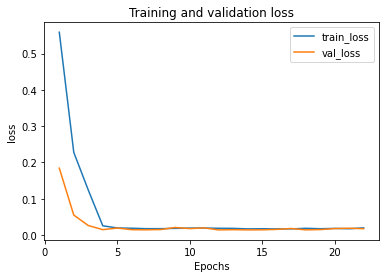

RMSE_LSTM = 10.9752871390887


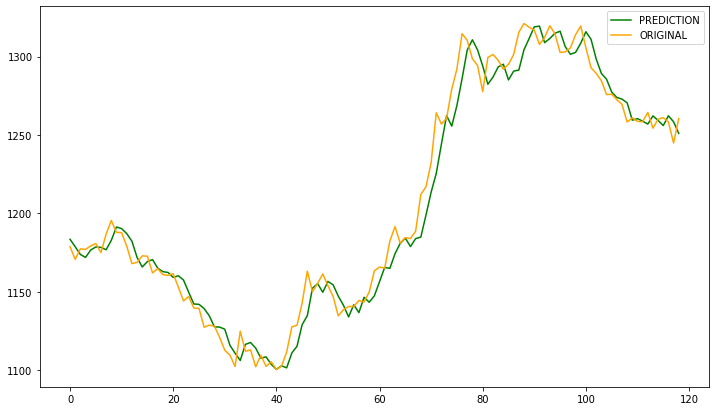

In [545]:
np.random.seed(60)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential()

# model.add(LSTM(96, input_shape=(xtr.shape[1], xtr.shape[2]), activation='tanh', return_sequences=True))
# model.add(Dropout(0.25))
# model.add(GlobalMaxPool1D())
# model.add(Dense(128, activation='linear'))
# model.add(Dropout(0.25))
model.add(
    LSTM(128, input_shape=(xtr.shape[1], xtr.shape[2]), activation='tanh', return_sequences=False)
    )
# model.add(
#     LSTM(96,activation='relu')
#     )
# model.add(Dense(64))
# model.add(Dense(64))

model.add(Dense(64, activation='sigmoid'))


model.add(Dense(1))
model.compile(optimizer='adam', loss= root_mean_squared_error)
# fit network

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(xtr, ytr, epochs=500, batch_size=32,verbose=0, validation_data=(xval, yval), 
                    callbacks=[early_stopping, mcp_save])

%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')


model.load_weights('model.hdf5')
# odel.evaluate(X_val, y_val, batch_size=4096)

plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(model.predict(xtest)), color='green', label='PREDICTION')
plt.plot(scaler.inverse_transform(ytest.reshape(-1, 1)), color='orange', label = 'ORIGINAL')
plt.legend()

from math import sqrt
from sklearn.metrics import mean_squared_error

RMSE_LSTM = sqrt(mean_squared_error(test_df.iloc[2:]['index'].values, scaler.inverse_transform(model.predict(xtest))))
print(f"RMSE_LSTM = {RMSE_LSTM}")

In [541]:
a = test_df.iloc[2:]
b = scaler.inverse_transform(model.predict(xtest))

In [542]:
a['preds'] = b
a['pred_change'] = a['preds'].pct_change()
a.fillna(0, inplace=True)
a['pred_target'] = np.where(a['pred_change'] <= 0 , 0, 1)
t_df = pd.read_csv('/content/final_indices.csv')
t_df = t_df[t_df['date'] > '2018-12-31']
a['real_target'] = t_df.iloc[2:]['target']
accuracy_score(a.real_target, a.pred_target)

0.5630252100840336

In [543]:
a.head(50)

,date,neg,neu,pos,target,index,index_scaled,preds,pred_change,pred_target,real_target
1119,2019-01-03,0.010275,0.830949,0.158775,0,1178.87,0.376294,1182.470459,0.000000,0,0
1120,2019-01-06,0.333411,0.545923,0.120666,0,1170.79,0.369121,1180.017334,-0.002075,0,0
1121,2019-01-07,0.334487,0.650366,0.015147,1,1177.46,0.375042,1174.724243,-0.004486,0,1
1122,2019-01-08,0.640127,0.333816,0.026057,0,1177.07,0.374696,1172.504517,-0.001890,0,0
1123,2019-01-09,0.263334,0.475368,0.261298,1,1179.36,0.376729,1176.169067,0.003125,1,1
1124,2019-01-10,0.084497,0.827201,0.088302,1,1180.84,0.378043,1177.558960,0.001182,1,1
1125,2019-01-13,0.348266,0.622583,0.029151,0,1175.05,0.372903,1178.344482,0.000667,1,0
1126,2019-01-14,0.113484,0.594510,0.292005,1,1186.80,0.383334,1177.987061,-0.000303,0,1
1127,2019-01-15,0.011055,0.698354,0.290591,1,1195.54,0.391092,1182.366943,0.003718,1,1
1128,2019-01-16,0.001010,0.971302,0.027688,0,1187.97,0.384372,1191.850952,0.008021,1,0


In [463]:
train_val = series_to_supervised(train_df[['index_scaled']], 1, 1)
valid_val = series_to_supervised(validation_df[['index_scaled']], 1, 1)
test_val = series_to_supervised(test_df[['index_scaled']], 1, 1)

In [464]:
xtr, ytr = train_val.values[:, :-1], train_val.values[:, -1]
xval, yval = valid_val.values[:, :-1], valid_val.values[:, -1]
xtest, ytest = test_val.values[:, :-1], test_val.values[:, -1]

In [465]:
xtr = xtr.reshape((xtr.shape[0], 1, xtr.shape[1]))
xval = xval.reshape((xval.shape[0], 1, xval.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))


In [466]:
xtr.shape, ytr.shape, xval.shape, xtest.shape

((880, 1, 1), (880,), (235, 1, 1), (120, 1, 1))

In [467]:
#Defining our metric
import tensorflow.keras.backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

Epoch 1/30
14/14 [==============================] - 2s 33ms/step - loss: 0.4169 - val_loss: 0.1004
Epoch 2/30
14/14 [==============================] - 0s 6ms/step - loss: 0.1555 - val_loss: 0.0389
Epoch 3/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0649 - val_loss: 0.0186
Epoch 4/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0270 - val_loss: 0.0126
Epoch 5/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0183 - val_loss: 0.0124
Epoch 6/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.0122
Epoch 7/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0127
Epoch 8/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0145
Epoch 9/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0131
Epoch 10/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0122
Epoch 11/30
14/14 

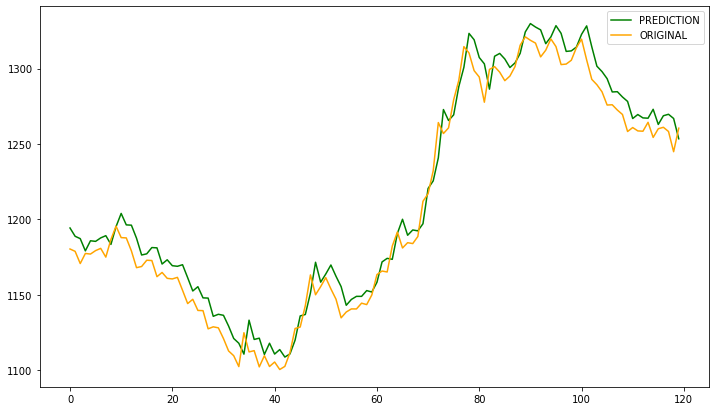

In [468]:
model = Sequential()

# model.add(LSTM(96, input_shape=(xtr.shape[1], xtr.shape[2]), activation='tanh', return_sequences=True))
# model.add(Dropout(0.25))
# model.add(GlobalMaxPool1D())
# model.add(Dense(128, activation='linear'))
# model.add(Dropout(0.25))
model.add(
    LSTM(188, input_shape=(xtr.shape[1], xtr.shape[2]), activation='tanh', return_sequences=False)
    )
# model.add(
#     LSTM(96,activation='tanh')
#     )
model.add(Dense(128))
# model.add(Dense(64))

model.add(Dense(1))
model.compile(optimizer='adam', loss= root_mean_squared_error)
# fit network
history = model.fit(xtr, ytr, epochs=30, batch_size=64,verbose=1, validation_data=(xval, yval))
plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(model.predict(xtest)), color='green', label='PREDICTION')
plt.plot(scaler.inverse_transform(ytest.reshape(-1, 1)), color='orange', label = 'ORIGINAL')
plt.legend()

from math import sqrt
from sklearn.metrics import mean_squared_error

RMSE_LSTM = sqrt(mean_squared_error(test_df.iloc[1:]['index'].values, scaler.inverse_transform(model.predict(xtest))))
print(f"RMSE_LSTM = {RMSE_LSTM}")

In [469]:
a = test_df.iloc[1:]
b = scaler.inverse_transform(model.predict(xtest))

In [470]:
a['preds'] = b
a['pred_change'] = a['preds'].pct_change()
a.fillna(0, inplace=True)
a['pred_target'] = np.where(a['pred_change'] <= 0 , 0, 1)
t_df = pd.read_csv('/content/final_indices.csv')
t_df = t_df[t_df['date'] > '2018-12-31']
a['real_target'] = t_df.iloc[1:]['target']
accuracy_score(a.real_target, a.pred_target)

0.525